# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 2:  $k$-NN and Linear Regression 

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [3]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

# <div class="theme"> Predicting Taxi Pickups in NYC </div>

In this homework, we will explore $k$-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York City at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

## <div class="exercise"> <b> Question 1  [13 pts]</b> </div>

**1.1 [2 pts]**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2 [3 pts]**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.

**1.3 [4 pts]**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4 [4 pts]**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.


### Answers

**1.1 [2 pts]. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.**

In [5]:
# read the file
# your code here

df = pd.read_csv("data/nyc_taxi.csv")
df.head()

,TimeMin,PickupCount,Day
0,860,33,Fri
1,17,75,Sun
2,486,13,Sun
3,300,5,Thu
4,385,10,Thu


In [8]:
# split the data
# your code here

train_data, test_data = train_test_split(df, test_size=0.2, random_state=109)

**1.2 [3 pts]. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.**

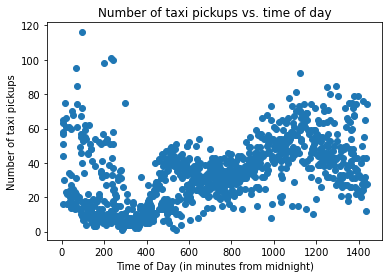

In [11]:
# your code here

plt.scatter(train_data['TimeMin'], train_data['PickupCount'])
plt.title('Number of taxi pickups vs. time of day')
plt.xlabel('Time of Day (in minutes from midnight)')
plt.ylabel('Number of taxi pickups')
plt.show()

**1.3 [4 pts]. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**



*your answer here*

There appears to be a sinusoidal relation between number of pickups and time of day. There is a slight decrease from midnight to 200 minutes past, then a continuous increase from 200 minutes past to 1100 minutes past, and lastly a decrease from 1100 minutes past to 1440 minutes past (to roughly initial position). This is reasonable as time of day is a periodic variable, and we would expect the lowest demand in the wee hours of the day, and the highest demand during rush hour (at around six pm).

**1.4 [4 pts]. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.**

*your answer here*

I speculate that this is due to difference between weekdays and weekends. During weekdays, there is a morning rush, so there would likely be more than 30 pickups at around nine am, whereas during weekends, people would not need a taxi as early (<20 needed) and so it follows the general increasing trend. The hole is thus caused by the gap in taxi demand between weekdays and weekends.

In [28]:
# your code here

weekends = pd.concat([train_data[train_data['Day'] == "Sat"], train_data[train_data["Day"] == "Sun"]])
weekends[weekends['TimeMin'].between(500, 550, inclusive=True)].describe()
# mean pickup count is 11.8 and median is 12.5 for weekends 

not_sat = train_data[train_data['Day'] != "Sat"]
weekdays = not_sat[not_sat['Day'] != "Sun"]
weekdays[weekdays['TimeMin'].between(500, 550, inclusive=True)].describe()
# mean pickup count is 41.7 and median is 41 for weekdays

,TimeMin,PickupCount
count,24.000000,24.000000
mean,526.541667,41.708333
std,14.823539,4.912089
min,501.000000,31.000000
25%,513.750000,38.750000
50%,529.500000,41.000000
75%,538.000000,44.750000
max,549.000000,51.000000


## <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen $k$-Nearest Neighbors ($k$-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run $k$-NN Regression. 


**2.1 [4 pts]**. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2 [6 pts]**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3 [3 pts]**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4 [3 pts]**. Plot, in a single figure, the two 'curves' of $R^2$ values from the models on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5 [9 pts]**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

### Answers

**2.1 [4 pts]. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`).**


In [6]:
# your code here

KNNModels = {}

ks = [1,10,75,250,500,750,1000]

for k in ks:
    KNNModels[k] = KNeighborsRegressor(n_neighbors=k)



**2.2 [5 pts].  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a line plot of predictions for `PickupCount` vs  a dummy `TimeMin` using `np.arange(np.min(train['TimeMin']),np.max(train['TimeMin']),1)`.  Do the same for the test set in separate plots.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set.** 

**Hints**:
1. Each subplot should use different color to distinguish k-NN regression prediction curve from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  

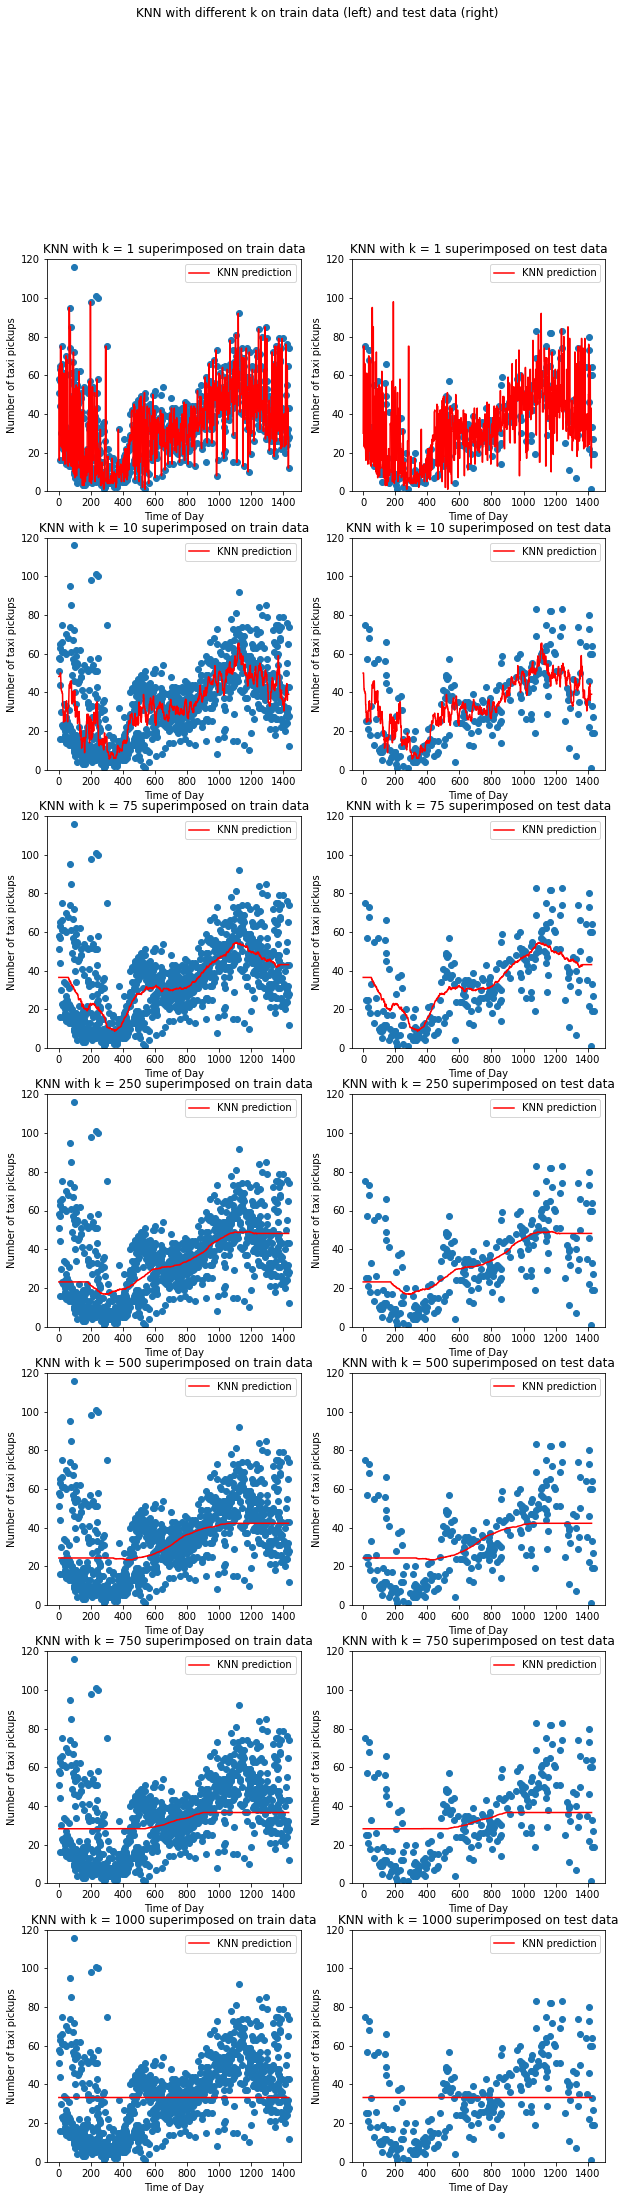

In [70]:
# your code here 

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10,35))

for i in range(7):
    model = KNNModels[ks[i]]
    
    model.fit(np.array(train_data['TimeMin']).reshape(-1, 1), np.array(train_data['PickupCount']).reshape(-1, 1))
    dum = np.arange(np.min(train_data['TimeMin']),np.max(train_data['TimeMin']),1)
    predictions = model.predict(dum.reshape(-1, 1))
    axes[i, 0].plot(predictions, color="red")
    axes[i, 0].scatter(train_data['TimeMin'], train_data['PickupCount'])
    axes[i, 0].set_ylim([0, 120])
    axes[i, 0].title.set_text(f'KNN with k = {ks[i]} superimposed on train data')
    axes[i, 0].set_xlabel('Time of Day')
    axes[i, 0].set_ylabel('Number of taxi pickups')
    axes[i, 0].legend(['KNN prediction'])

    dumtest = np.arange(np.min(test_data['TimeMin']),np.max(test_data['TimeMin']),1)
    predictions = model.predict(dumtest.reshape(-1, 1))
    axes[i, 1].plot(predictions, color="red")
    axes[i, 1].scatter(test_data['TimeMin'], test_data['PickupCount'])
    axes[i, 1].set_ylim([0, 120])
    axes[i, 1].title.set_text(f'KNN with k = {ks[i]} superimposed on test data')
    axes[i, 1].set_xlabel('Time of Day')
    axes[i, 1].set_ylabel('Number of taxi pickups')
    axes[i, 1].legend(['KNN prediction'])
    
fig.suptitle('KNN with different k on train data (left) and test data (right)')
plt.show()



In [ ]:
# Plot predictions vs actual
# your code here 



**2.3 [3 pts]. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**



In [85]:
# your code here

knntrain = []
knntest = []
for i in range(7):
    model = KNNModels[ks[i]]
    model.fit(np.array(train_data['TimeMin']).reshape(-1, 1), np.array(train_data['PickupCount']).reshape(-1, 1))
    yhat1_train = model.predict(np.array(train_data[['TimeMin']]).reshape(-1, 1))
    yhat1_test = model.predict(np.array(test_data[['TimeMin']]).reshape(-1, 1))
    
    r2_train = sk.metrics.r2_score(train_data['PickupCount'], yhat1_train)
    knntrain.append(r2_train)
    r2_test = sk.metrics.r2_score(test_data['PickupCount'], yhat1_test)
    knntest.append(r2_test)
    
results1 = pd.DataFrame(index = ["k = 1", "k = 10", "k = 75", "k = 250", "k = 500", "k = 750", "k = 1000"])
results1['train r2'] = knntrain
results1['test r2'] = knntest

results1


,train r2,test r2
k = 1,0.667533,-0.074464
k = 10,0.469673,0.414593
k = 75,0.418806,0.479658
k = 250,0.343803,0.394991
k = 500,0.276392,0.302357
k = 750,0.169987,0.179605
k = 1000,0.000000,-0.000032


**2.4 [3 pts]. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.



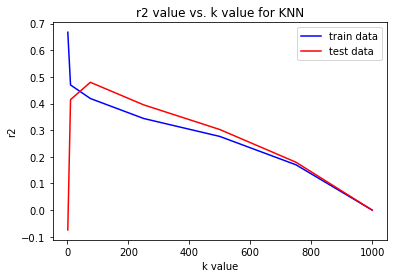

In [89]:
# your code here

plt.plot(ks, results1["train r2"], color="blue")
plt.plot(ks, results1["test r2"], color="red")
plt.xlabel("k value")
plt.ylabel("r2")
plt.title("r2 value vs. k value for KNN")
plt.legend(["train data", "test data"])
plt.show()



**2.5 [9 pts]. Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

The regression model would just be a flat line that is equal to the average of all the data points.

2. What does an $R^2$ score of $0$ mean?  

This means that the regression model matches the data as good as a flat line that is equal to the average of all the data points.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

This means that the regression model matches the data worse than a line that is equal to the average of all the data points.

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

They do exhibit different trends. The $R^2$ value for the training data strictly decreases (and approaches 0) with higher k values as $k = n$ would suggest a flat line that is equal to the average of all the data points. On the other hand, the $R^2$ value for the testing data increases from $k = 1$ to roughly $k = 75$ before decreasing as k gets larger (and approaches 0).

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

The best value of k is 75, because from the table it yielded the highest $R^2$ value for the test data. The $R^2$ values are higher for training data from $k = 1$ to roughly $k = 25$. After this point, it appears that the test set has a higher $R^2$ value than the training set.

6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

It would be the inverse of the $R^2$ plot as MSE would be essentially 0 for training data when $k = 1$, and increase in size to $k = 1000$. Meanwhile for testing data, there will be a positive quadratic shape (instead of the current negative quadratic shape) as there may be a minimum for MSE at around $k = 75$.

## <div class="exercise"> <b> Question 3 [23 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1 [3 pts]**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2 [3 pts]**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4 [2 pts]**. Report the estimates for the slope and intercept for the fitted linear model.

**3.5 [3 pts]**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6 [10 pts]**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers



**3.1 [3 pts]. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.**



In [115]:
# your code here
import statsmodels.regression.linear_model as lm

X = sm.tools.add_constant(train_data['TimeMin'])
OLSModel = lm.OLS(train_data['PickupCount'],X)
results = OLSModel.fit()
results.params

# OLSModel = LinearRegression(fit_intercept=True).fit(train_data['TimeMin'].values.reshape(-1, 1), train_data['PickupCount'])

# print("Beta0 =", OLSModel.intercept_ ,", Beta1 =", OLSModel.coef_)

/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const      17.341910
TimeMin     0.022715
dtype: float64

**3.2 [3 pts]. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.**

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  



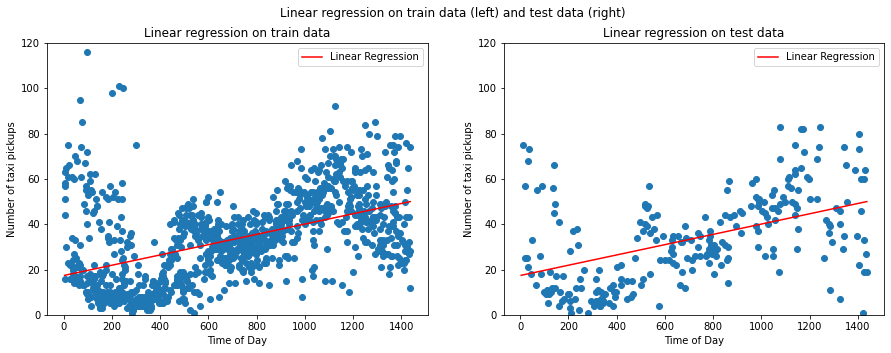

In [147]:
# your code here

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# yhat_dummy_regress = OLSModel.predict(dum.reshape(-1, 1))
yhat_dummy_regress = results.params['const']+results.params['TimeMin']*dum


axes[0].scatter(train_data['TimeMin'],train_data['PickupCount'])
axes[0].plot(dum,yhat_dummy_regress,c="r",label="Linear Regression")
axes[1].scatter(test_data['TimeMin'],test_data['PickupCount'])
axes[1].plot(dum,yhat_dummy_regress,c="r",label="Linear Regression")

dat = ['train', 'test']

for i in range(2):
    axes[i].set_ylim([0, 120])
    axes[i].title.set_text(f'Linear regression on {dat[i]} data')
    axes[i].set_xlabel('Time of Day')
    axes[i].set_ylabel('Number of taxi pickups')
    axes[i].legend(['Linear Regression'])
    
fig.suptitle('Linear regression on train data (left) and test data (right)')
plt.show()

In [ ]:
# your code here 


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.



In [122]:
# your code here

knntrain = []
knntest = []

yhat1_train = results.params['const']+results.params['TimeMin']*train_data['TimeMin']
yhat1_test = results.params['const']+results.params['TimeMin']*test_data['TimeMin']

r2_train = sk.metrics.r2_score(train_data['PickupCount'], yhat1_train)
knntrain.append(r2_train)
r2_test = sk.metrics.r2_score(test_data['PickupCount'], yhat1_test)
knntest.append(r2_test)
    
results1 = pd.DataFrame(index = [""])
results1['train r2'] = knntrain
results1['test r2'] = knntest

results1

,train r2,test r2
,0.234577,0.270916


**3.4 [2 pts]. Report the estimates for the slope and intercept for the fitted linear model.**



In [123]:
# your code here
# print("Beta0 =", OLSModel.intercept_ ,", Beta1 =", OLSModel.coef_)

results.params

# Beta0 = 17.341909774869507 , Beta1 = [0.02271549]

const      17.341910
TimeMin     0.022715
dtype: float64

**3.5 [3 pts]. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 



In [124]:
# your code here

OLSModel.fit().summary()

# Beta0 95% confidence interval = [15.282, 19.402], Beta1 = [0.020, 0.025]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     305.9
Date:                Tue, 06 Jul 2021   Prob (F-statistic):           6.06e-60
Time:                        16:57:27   Log-Likelihood:                -4225.3
No. Observations:                1000   AIC:                             8455.
Df Residuals:                     998   BIC:                             8464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3419      1.050     16.519      0.000      15.282      19.402
TimeMin        0.0227      0.001     17.489      0.000       0.020       0.025
==============================================================================
Omnibus:                      231.966   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.753
Skew:                           1.202   Prob(JB):                    3.53e-131
Kurtosis:                       5.939   Cond. No.                     1.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**3.6 [10 pts]. Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

The test $R^2$ score of 0.27 is worse than the best test $R^2$ value obtained with k-NN regression of 0.47. This is not surprising as we can see the data appears sinusoidal (and not linear), so a linear model is expected to perform worse in fitting the data (and is closer to a flat line model).

2. What does the sign of the slope of the fitted linear model convey about the data?  

The sign is positive, so it conveys that as time progresses from midnight, there will be more and more people using taxis. In fact, with each passing minute, it expects 0.02 more people to grab a taxi than the previous minute.

3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 

It does appear that there is a significant linear relationship  between number of taxi pickups and time of day, because the 95% confidence interval does not include 0. Thus, the model suggests that there is indeed a positive relationship. 

** how to deal with beta 0 confidence interval **

4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  

99% confidence intervals will have the same midpoint for slope and intercept, but will be wider. This is because confidence intervals are centered on the predicted value (and expand for 3 standard deviations on both sides for 99% and just 2 standard deviations for 95%). This makes the 99% interval wider.

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

Based on the data structure, we should have $x\approx0$ and $x\approx1440$ have the same predicted y-value as they are both midnight. However, this does not happen with our linear model, which suggests a linear model is not very appropriate for this data set.

## <div class="exercise"> <b> Question 4 [12 pts] </b></div>

We next consider investigating how the day of the week is associated with pickups to improve both the predictive accuracy of the models and help with more in depth interpretations.  We begin by using the non-parametric *k*-NN approach.   

**4.1 [2 pts]**. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday. 

**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.

**4.3 [3 pts]**. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot). 

**4.4 [4 pts]**. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.






### Answers


**4.1 [2 pts]. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday.** 



In [148]:
# your code here

# df["Weekend"] = (df['Day'] == "Sat") | (df["Day"] == "Sun")
# df.head()

train_data["Weekend"] = 1 * ((train_data['Day'] == "Sat") | (train_data["Day"] == "Sun"))
train_data.head()


test_data["Weekend"] = 1 * ((test_data['Day'] == "Sat") | (test_data["Day"] == "Sun"))
test_data.head()

,TimeMin,PickupCount,Day,Weekend
1052,486,34,Mon,0
916,420,13,Sat,1
284,1138,75,Sat,1
176,645,22,Thu,0
219,1140,62,Fri,0


**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.


In [176]:
# your code here
knnreg75 = KNeighborsRegressor(n_neighbors=75)
# X = train_data["Weekend"] * 1600 + train_data["TimeMin"]

train_data["Weekend"] = 1600 * train_data["Weekend"]
knnreg75.fit(np.array(train_data[['TimeMin','Weekend']]).reshape(-1,2), train_data['PickupCount'])

KNeighborsRegressor(n_neighbors=75)

**4.3 [3 pts]. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot).**


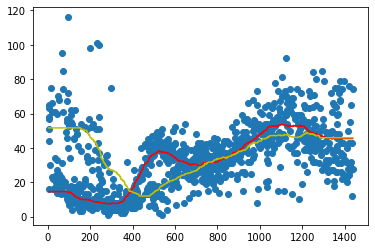

In [185]:
# your code here
xgrid_wday = pd.DataFrame(np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1), columns=["TimeMin"])
xgrid_wday["Weekend"] = np.zeros((len(xgrid)), dtype=float)

xgrid_wend = pd.DataFrame(np.arange(np.min(train_data['TimeMin']), np.max(train_data['TimeMin']), 1), columns=["TimeMin"])
xgrid_wend["Weekend"] = 1600 * np.ones((len(xgrid)), dtype=float)

predictions_weekdays = knnreg75.predict(xgrid_wday)
predictions_weekends = knnreg75.predict(xgrid_wend)

plt.scatter(train_data['TimeMin'], train_data['PickupCount'])
plt.plot(xgrid, predictions_weekdays, label="predicted data", c='r');
plt.plot(xgrid, predictions_weekends, label="predicted data", c='y');

# overlay on test or train data?
# Needs to add number greater than k-value + 1440, so picked 1600


**4.4 [4 pts]. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.**


*your answer here*

On one hand, for weekends, there is generally a dip between midnight and 10am before increasing a bit and plateauing. On the other hand, for weekdays, there is much more fluctuation. While following a general pattern of the weekends, it has peaks at 9am and 5pm (which are rush hours), so the trends make sense. In addition, there are many more rides in the wee hours of the weekend, which make sense as most parties occur then.

##### <div class="exercise"> <b> Question 5 [27 pts] </b></div>

Finally we turn to multiple regression models to see if there is a weekend affect.  Note: Use sklearn to do the modeling unless otherwise stated.


**5.1 [6 pts]**. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.

**5.2 [6 pts]**. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.

**5.3 [3 pts]**. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.

**5.4 [4 pts]**. Determine if the model in 5.3 is a more accurate model than the *k*-NN model in 4.2.  Why do you suppose this is the case?

**5.5 [5 pts]**. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot of the training data). How does this compare to the plot from 4.3?

**5.6 [3 pts]**. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.

### Answers

**5.1 [6 pts]. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:**

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.


In [169]:
# your code here

X = sm.tools.add_constant(train_data[['TimeMin','Weekend']])
model2 = lm.OLS(train_data['PickupCount'],X).fit()
model2.summary()

# regress2_2 = LinearRegression(fit_intercept=True).fit(train[['log_minority','log_density']], train['votergap'])
# print("Beta0 =", regress2_2.intercept_ ,", Beta's =", regress2_2.coef_)

/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     164.4
Date:                Tue, 06 Jul 2021   Prob (F-statistic):           1.93e-62
Time:                        22:56:24   Log-Likelihood:                -4216.4
No. Observations:                1000   AIC:                             8439.
Df Residuals:                     997   BIC:                             8454.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7475      1.107     14.220      0.000      13.574      17.921
TimeMin        0.0228      0.001     17.665      0.000       0.020       0.025
Weekend        4.6383      1.098      4.223      0.000       2.483       6.793
==============================================================================
Omnibus:                      183.150   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.494
Skew:                           1.008   Prob(JB):                     1.63e-90
Kurtosis:                       5.421   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*your answer here*

The coefficient for TimeMin is 0.0228 which is about the same for Linear Regression with just TimeMin. Thus, it appears that there is not much confounding with TimeMin. 

# interpret later


**5.2 [6 pts]. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.**



In [193]:
# your code here
r2s = []

for i in range(2, 7):
    model = PolynomialFeatures(i, include_bias=False).fit_transform(np.array(train_data['TimeMin']).reshape(-1, 1))
    fitted_model = LinearRegression().fit(model, train_data["PickupCount"])
    
    testmodel = PolynomialFeatures(i, include_bias=False).fit_transform(np.array(test_data['TimeMin']).reshape(-1, 1))
    r2 = fitted_model.score(testmodel, test_data["PickupCount"])
    r2s.append(r2)

print(r2s)

# Since polynomial degree 5 had highest r2 of 0.44 then it is the best model.
    

[0.2797420802532561, 0.4204172737999097, 0.42374830469188085, 0.4402604559360149, 0.40961917112377944]


**5.3 [3 pts]. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.**


In [ ]:
# your code here


**5.4 [4 pts]. Determine if the model in 5.3 is a more predictive model than the *k*-NN model in 4.2.  Why do you suppose this is the case?**



In [ ]:
# your code here

*your answer here*

**5.5 [5 pts]. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot). How does this compare to the plot from 4.3?**



In [ ]:
# your code here

*your answer here*

**5.6 [3 pts]. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.**

*your answer here*

Holidays or Weather (Boston rain a lot!)